In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parents[1]
sys.path.insert(0, str(project_root))

print("Added to sys.path:", project_root)


Added to sys.path: c:\Users\eduar\Documents\RDEPro_github_clean\rdepro_skrub_provenance


In [2]:
# Olist Churn Prediction with Complete Visual Analytics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
from xgboost import XGBClassifier, plot_importance      # i thought xgboost is defined already in scikit learn
import shap
import warnings
import skrub
from skrub import ToDatetime
from skrub import DatetimeEncoder
# warnings.filterwarnings("ignore")
#PROVENANCE MODULE
from monkey_patching_v02.data_provenance.monkey_patching_v02_data_provenance import set_provenance, enter_provenance_mode_dataop, enter_provenance_mode_var
set_provenance(skrub._data_ops._evaluation,"evaluate", provenance_func=enter_provenance_mode_dataop)
set_provenance(skrub._data_ops._data_ops.Var,"compute", provenance_func=enter_provenance_mode_var)

In [3]:
from functools import wraps
def enter_skrub_learner_provenance(func):
    @wraps(func)
    def wrapper(*args,**kwargs):
        
        # print("we are here")
        # print("arguemnts")
        for arg in args:
            # print(arg)
            # print()
            if isinstance(arg, dict):
                # print("In the following dataframe, the _prov columns should be dropped")
                # print(arg['_skrub_X'])
                if "_skrub_X" in arg.keys():
                    arg['_skrub_X'] = arg['_skrub_X'].drop(columns=[col for col in arg['_skrub_X'].columns if col.startswith("_prov")])
        result = func(*args,**kwargs)
        
        # TODO: maybe reattach _prov cols to arg later
        # print("result is ", result)

        return result # Just execute the function and get the result
    return wrapper


set_provenance(skrub._data_ops._estimator.SkrubLearner, "_eval_in_mode", enter_skrub_learner_provenance)

In [4]:
from skrub import SelectCols

In [ ]:
# # Force install NumPy < 2.0
# %pip install numpy==1.26.4 --upgrade --force-reinstall

# # Reinstall other libraries that depend on NumPy
# %pip install --force-reinstall matplotlib scikit-learn shap xgboost


In [5]:
# Load data
#order_items = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')
#order_payments = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')
#order_reviews = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv')

customers = pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_customers_dataset.csv')
orders = pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_orders_dataset.csv')
order_items = skrub.var("order_items", pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_order_items_dataset.csv'))
order_payments = skrub.var("order_payments",pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_order_payments_dataset.csv'))
order_reviews = skrub.var("order_reviews", pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_order_reviews_dataset.csv'))


In [6]:
# Preprocessing
# df = pd.merge(orders, customers, on='customer_id')
df = skrub.var("df", orders.merge(customers, on="customer_id"))#[:10_000])
df = df[df['order_status'] == 'delivered']
#df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
toDatetimeEncoder = ToDatetime() 
df= df.skb.apply(toDatetimeEncoder, cols= 'order_purchase_timestamp')

latest_date = df['order_purchase_timestamp'].max()
cutoff = latest_date - timedelta(days=180)
last_order = df.groupby('customer_unique_id').agg({"order_purchase_timestamp":"max"}).reset_index()
#last_order['churn'] = (last_order['order_purchase_timestamp'] < cutoff).astype(int)
last_order = last_order.assign(churn = (last_order['order_purchase_timestamp'] < cutoff).astype(int))
# display(last_order)

order_counts = df.groupby('customer_unique_id').size().reset_index(name='order_count')

# print("does this df contain any _prov column?")
# print(order_counts) # no.. TODO: reattach the prov column after size -> provenance tracking breaks here, but it is a minor bag -> i will fix it
# print("#"*80)

price = order_items.groupby('order_id').agg({'price':"sum"}).reset_index()
payment = order_payments.groupby('order_id').agg({'payment_value':"sum"}).reset_index()

features = df.merge(last_order, on='customer_unique_id')

features = features.merge(order_counts, on='customer_unique_id')
features = features.merge(price, on='order_id', how='left') 
features = features.merge(payment, on='order_id', how='left')
# features = features[['customer_unique_id', 'order_count', 'price', 'payment_value', 'churn']].dropna()  # -> instead use SelectCols
features = features.skb.apply(SelectCols(['customer_unique_id', 'order_count', 'price', 'payment_value', 'churn'])).dropna()
features = features.groupby('customer_unique_id').agg({
    'order_count': 'max',
    'price': 'mean',
    'payment_value': 'mean',
    'churn': 'max'
}).reset_index()



In [7]:
# Model input
#X = features.drop(['customer_unique_id', 'churn'], axis=1)
#y = features['churn']
Xpre =  features.drop(['customer_unique_id', 'churn'], axis=1)
y = features['churn'].skb.mark_as_y()

scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
X = (Xpre.skb.apply(scaler)).skb.mark_as_X()

#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
#model.fit(X_train, y_train)
#y_pred = model.predict(X_test)
#y_proba = model.predict_proba(X_test)[:, 1] 
#CANNOT FIND SKRUB EQUIVALENT TO THIS
delayed = X.skb.apply(model, y=y)
# delayed_clean = delayed.drop(
#     columns=["_prov0_x", "_prov0_y", "_prov1", "_prov2"]
# )
split = delayed.skb.train_test_split(random_state= 0)
learner = delayed.skb.make_learner()
learner.fit(split["train"])
learner.score(split["test"])
pred = learner.predict(split["test"])

c:\Users\eduar\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [10:00:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\eduar\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [10:00:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [8]:
pred

array([1, 1, 1, ..., 0, 1, 1], shape=(23340,))

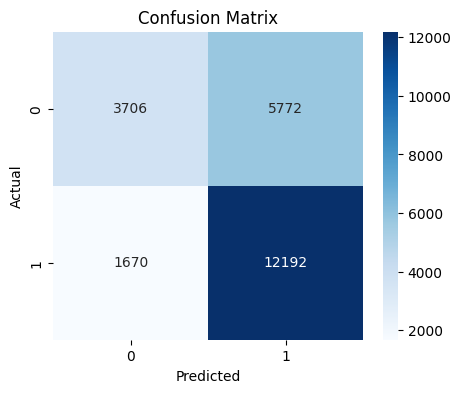

In [9]:
# Confusion Matrix
cm = confusion_matrix(split["y_test"], pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

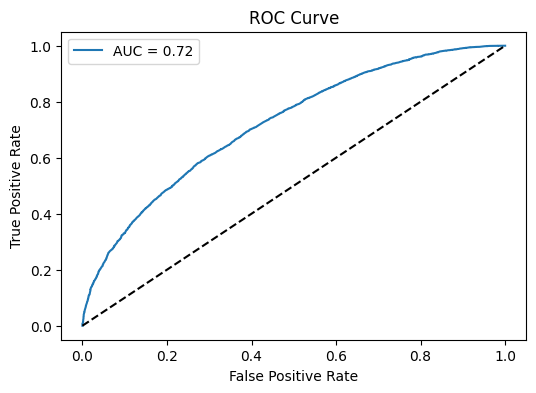

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(split["y_test"], y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

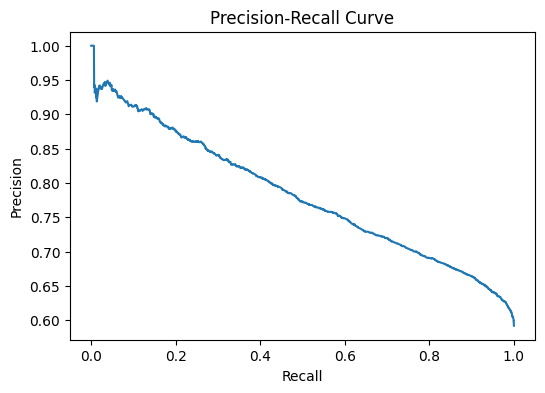

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

<Figure size 700x500 with 0 Axes>

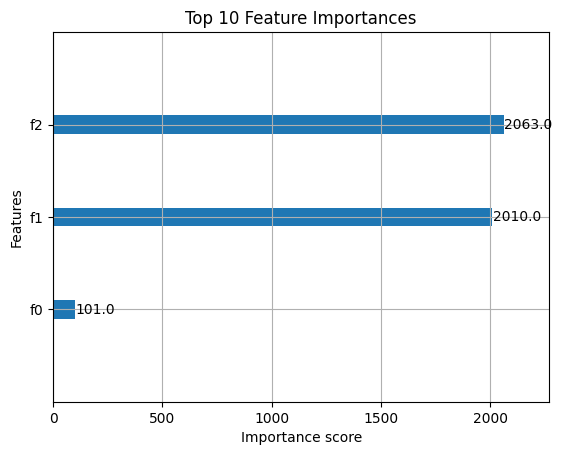

In [ ]:
# Feature Importance
plt.figure(figsize=(7, 5))
plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

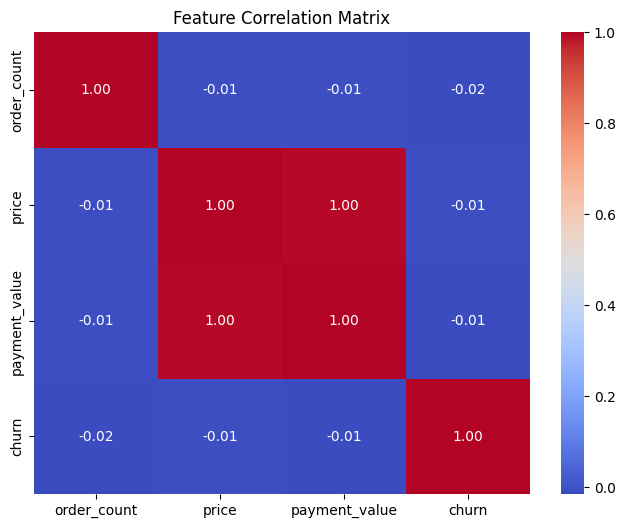

In [ ]:
# Correlation Heatmap
df_corr = pd.DataFrame(X_scaled, columns=X.columns)
df_corr['churn'] = y.values
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

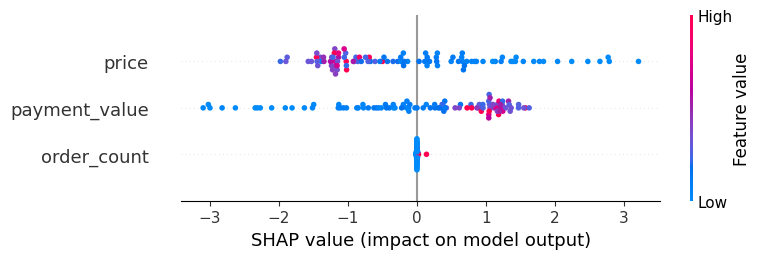

In [ ]:
# SHAP Summary
explainer = shap.Explainer(model)
shap_values = explainer(X_train[:100])  # Limit for performance
shap.summary_plot(shap_values, features=X_train[:100], feature_names=X.columns)

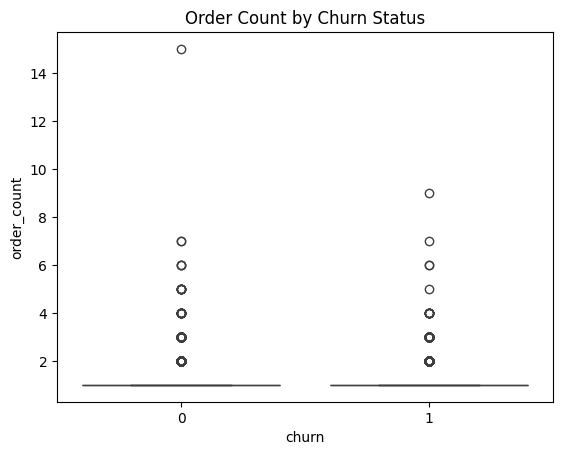

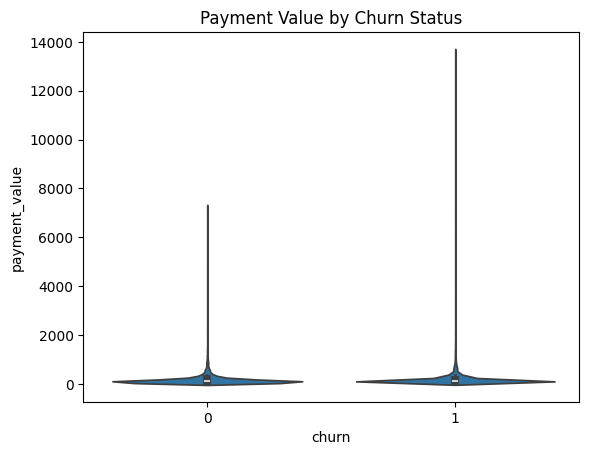

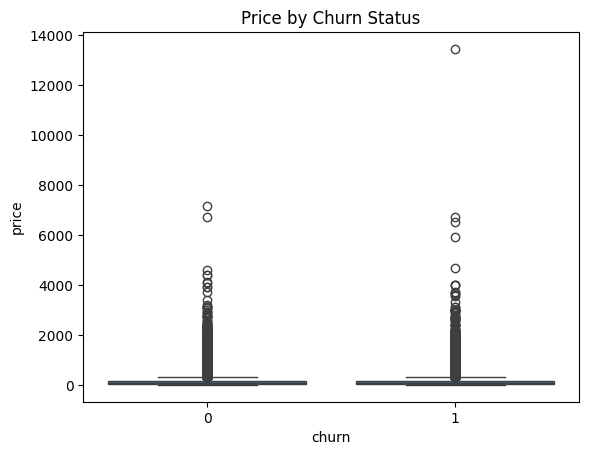

In [ ]:
# Boxplots for Feature Distributions
sns.boxplot(x=features['churn'], y=features['order_count'])
plt.title("Order Count by Churn Status")
plt.show()

sns.violinplot(x=features['churn'], y=features['payment_value'])
plt.title("Payment Value by Churn Status")
plt.show()

sns.boxplot(x=features['churn'], y=features['price'])
plt.title("Price by Churn Status")
plt.show()

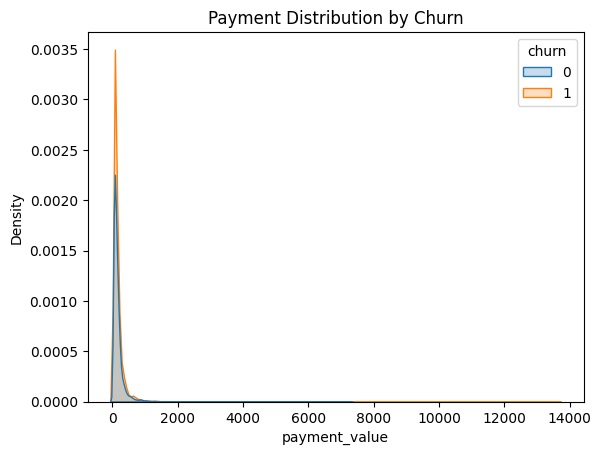

In [ ]:
# KDE of payment_value
sns.kdeplot(data=features, x="payment_value", hue="churn", fill=True)
plt.title("Payment Distribution by Churn")
plt.show()

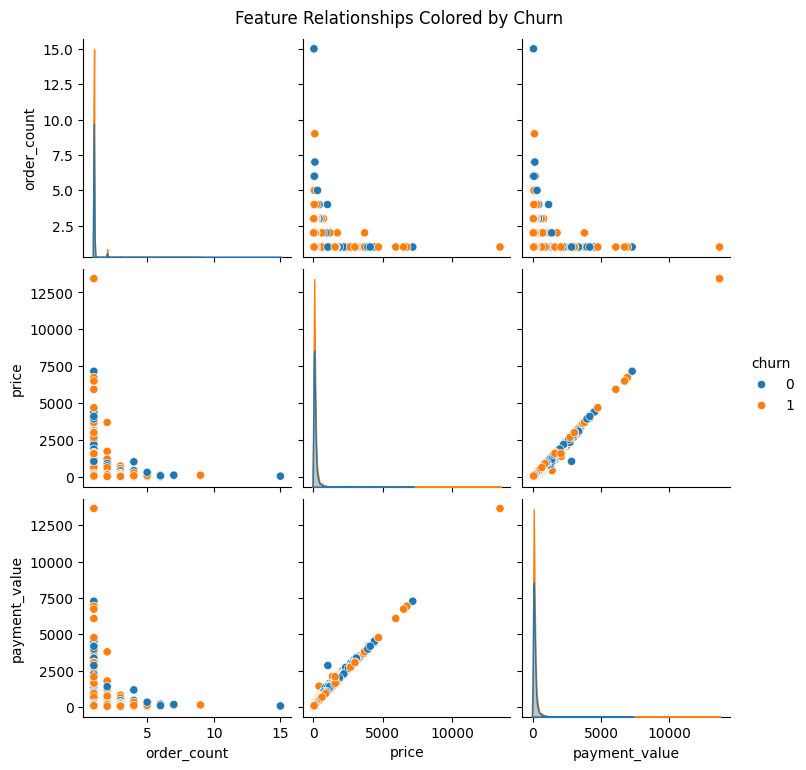

In [ ]:
# Pairplot
sns.pairplot(features.drop(columns=['customer_unique_id']), hue='churn')
plt.suptitle("Feature Relationships Colored by Churn", y=1.02)
plt.show()

In [ ]:
# Pandas approach -> takes less than 5 seconds to execute -> this is the setup
# Olist Churn Prediction with Complete Visual Analytics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
from xgboost import XGBClassifier, plot_importance      # i thought xgboost is defined already in scikit learn
import shap
import warnings
import skrub
from skrub import ToDatetime
from skrub import DatetimeEncoder
warnings.filterwarnings("ignore")
#PROVENANCE MODULE
from monkey_patching_v02_data_provenance import set_provenance, enter_provenance_mode_dataop, enter_provenance_mode_var
# set_provenance(skrub._data_ops._evaluation,"evaluate", provenance_func=enter_provenance_mode_dataop)
# set_provenance(skrub._data_ops._data_ops.Var,"compute", provenance_func=enter_provenance_mode_var)

customers = pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_customers_dataset.csv')
orders = pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_orders_dataset.csv')
order_items = skrub.var("order_items", pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_order_items_dataset.csv'))
order_payments = skrub.var("order_payments",pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_order_payments_dataset.csv'))
order_reviews = skrub.var("order_reviews", pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_order_reviews_dataset.csv'))
# Preprocessing
df = pd.merge(orders, customers, on='customer_id')
# df = skrub.var("df", orders.merge(customers, on="customer_id"))#[:10_000])
df = df[df['order_status'] == 'delivered']
#df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
toDatetimeEncoder = ToDatetime() 
# df= df.skb.apply(toDatetimeEncoder, cols= 'order_purchase_timestamp')

latest_date = df['order_purchase_timestamp'].max()
# cutoff = latest_date - timedelta(days=180)
display(df)
print("here ")
df["_prov"] = np.arange(len(df["order_id"]))

#Execution
# last_order = df.groupby('customer_unique_id').agg({"order_purchase_timestamp":"max",
#                                                    "_prov":list}).reset_index()
# last_order